### Pathfinding of flying drones using rapidly exploring random tree (RRT) algorithm

In this notebook, we will use the rapidly-exploring random tree (RRT) algorithm to find a suitable flight trajectory for a drone. RRT is a motion planning algorithm that creates a tree of possible paths by randomly sampling points in space and connecting these points to the nearest branch in the tree. RRT* is an extension of RRT that uses cost-based optimization to improve the quality of the path. Informed RRT* is another extension that uses an informed sampling strategy to bias the sampling towards areas of the space that are more likely to contain a valid solution.

We will showcase how RRT can be implemented to find a path for a drone in a simulated environment. We will compare the performance of different variations of RRT, including the standard RRT, RRT*, and informed RRT*. We will progressively increase the complexity of the scenarios to test the capabilities of each RRT algorithm. 

In [1]:
# Imports
import numpy as np
import gym
import ipywidgets
from matplotlib import pyplot as plt

from controller.Quadrotor import Quadrotor
from controller.linear_controller import LinearPDController
from controller.nonlinear_controller import NonLinearPDController
from controller.trajectory import CustomTrajectory, CircleTrajectory, DiamondTrajectory, TUDTrajectory, HoverTrajectory, PosVelAccTrajectory

from RRT_planning.rrt_tools import GridMap, Configuration
from RRT_planning.RRT_algorithms.graphrrt import RRTPlanner
from RRT_planning.RRT_algorithms.rrt_star1 import RRTPlanner as RRTStarPlanner
from RRT_planning.RRT_algorithms.informed_rrt_star import RRTPlanner as InformedRRTStarPlanner
from RRT_planning.utils import RRTVariant

%matplotlib widget 

In [2]:
# Choose parameters

freq = 100 
simulation_time = 100

controller_name = "nonlinear" # ["nonlinear", "linear"] 
controller = NonLinearPDController()
#controller = LinearPDController()

dt = 1/freq
env = gym.make('Quadrotor-v0', disable_env_checker=True) # disable_env_checker to supress setup warnings

c:\Users\niels\anaconda3\lib\site-packages\gym\spaces\box.py:127: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(f"Box bound precision lowered by casting to {self.dtype}")


#### RRT path planning with obstacles

In [3]:
# Set environment
grid = GridMap(100,100,100)

environment = 1

# 3 spheres on the path
if(environment == 1):
    grid.addObstacles(25,25,25, radius=10)
    grid.addObstacles(70,70,70, radius=10)
    grid.addObstacles(50,50,50, radius=10)

# Wall in center
if(environment == 2):
    grid.addRectangle(40, 40, 40, 6, 60, 80)

# Pillar in center
if(environment == 3):
    grid.addRectangle(40, 40, 40, 30, 30, 80)

# Maze
if(environment == 4):
    grid.addRectangle(20, 30, 40, 2, 60, 100)
    grid.addRectangle(20, 90, 40, 2, 20, 100)

    grid.addRectangle(40, 10, 40, 2, 20, 100)
    grid.addRectangle(40, 70, 40, 2, 60, 100)

    grid.addRectangle(60, 30, 40, 2, 60, 100)
    grid.addRectangle(60, 90, 40, 2, 20, 100)



Using Vanilla RRT
Initialized RRT Planner with
startErrorMargin 100
goalErrorMargin 100
maxTimeTaken 10
maxNodesExpanded 10000
Found good enough end configuration Position (74, 82, 87) yaw 0.0 with error 98.86960440108936
Number of nodes expanded 451 and time taken 0.43797755241394043
Total battery spent finishing task : 43986.27411061523
Total battery spent finishing task with smoothing: 3861.037914372359


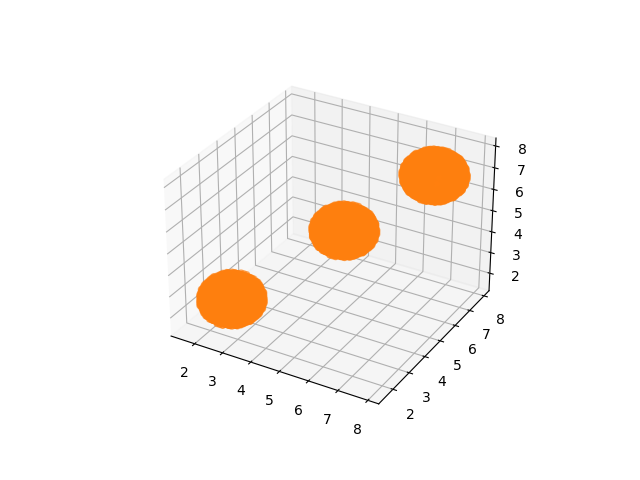

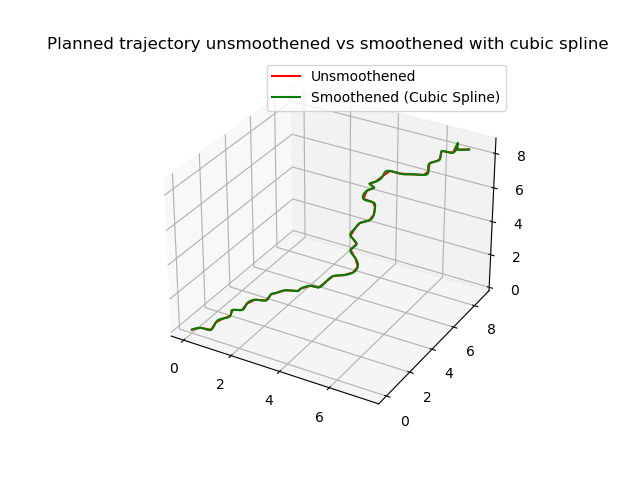

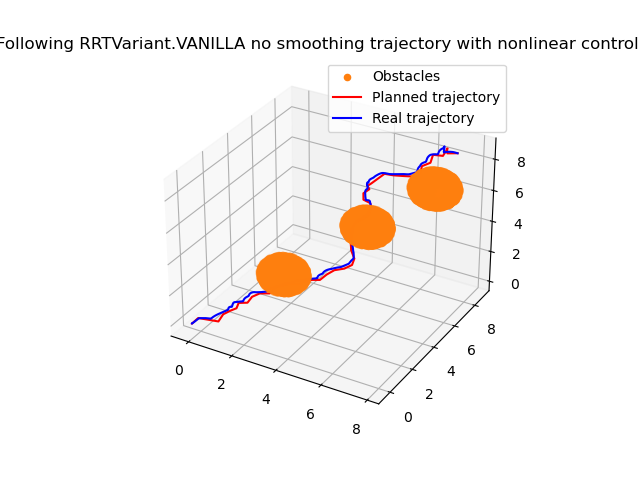

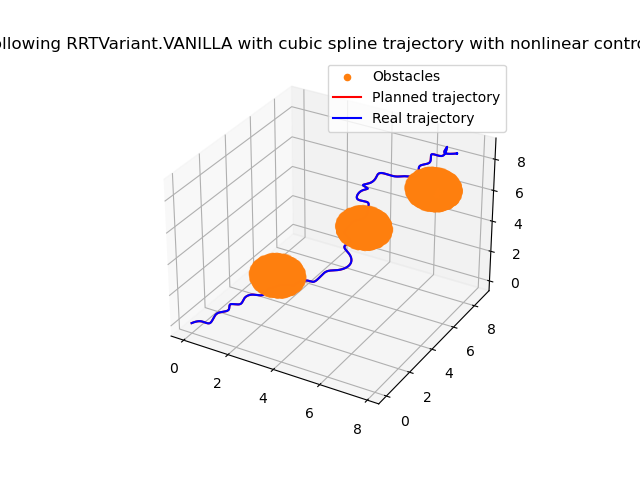

In [4]:
from RRT_planning.cubic_spline import getCubicSpline

resolution = 0.1
connectorLength = 5
searchTimeout = 10
sqnorm_err = lambda x1,x2 : (x1-x2)**2
T = 30
plannerName = RRTVariant.VANILLA
if plannerName == RRTVariant.VANILLA:
    print("Using Vanilla RRT")
    planner = RRTPlanner(grid, connectorLength=connectorLength, maxTimeTaken=searchTimeout)
elif plannerName == RRTVariant.STAR:
    print("Using RRT Star")
    planner = RRTStarPlanner(grid, connectorLength=connectorLength, maxTimeTaken=searchTimeout)
elif plannerName == RRTVariant.INFORMED:
    print("Using informed RRT*")
    planner = InformedRRTStarPlanner(grid, connectorLength = connectorLength, maxTimeTaken=searchTimeout)

# Plotting the static map
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
x, y, z = grid.getMap().nonzero()
xMap = x * resolution
yMap = y * resolution
zMap = z * resolution
ax.scatter(xMap,yMap,zMap, 'g', c='#ff7f0e')

# Provide start and end goal configuration
startConfig = Configuration(0,0,0)
goalConfig = Configuration(80,80,80, np.pi)
# Run search to get trajectory
traj = planner.getTrajectory(startConfig, goalConfig)

def feedRRTTrajectory(trajectory : CustomTrajectory):
    t = 0
    start_pos = trajectory.getDesState(t)['x']
    end_pos = trajectory.getDesState(simulation_time)['x']
    cur_state = env.reset(position=start_pos)

    plan_trajectory = {'x' : [], 'y' : [], 'z' : []}
    real_trajectory = {'x' : [], 'y' : [], 'z' : []}
    w_history = []
    while t < simulation_time:
        des_state = trajectory.getDesState(t)
        ctrl_var = controller.control(des_state, cur_state)
        action = ctrl_var['cmd_motor_speeds']
        cur_state, reward, done, info = env.step(action)

        plan_trajectory['x'].append(des_state['x'][0])
        plan_trajectory['y'].append(des_state['x'][1])
        plan_trajectory['z'].append(des_state['x'][2])

        cur_x = cur_state['x'][0]
        cur_y = cur_state['x'][1]
        cur_z = cur_state['x'][2]

        real_trajectory['x'].append(cur_x)
        real_trajectory['y'].append(cur_y)
        real_trajectory['z'].append(cur_z)
        
        w_history.append(cur_state['w'])

        t += dt
    end_pos_err = np.sum(sqnorm_err(end_pos, np.array([cur_x, cur_y, cur_z]) ))
    reachedGoal = end_pos_err < 1
    return plan_trajectory, real_trajectory, w_history, reachedGoal


if traj != []:
    # If trajectory is found
    traj = np.array([(point.pos.x * resolution, point.pos.y * resolution , point.pos.z * resolution) for point in traj])
    trajWithProfile = CustomTrajectory(dt, traj, T=T, name=f"{plannerName} no smoothing")
    
    # Plot of unsmoothened planned trajectory
    fig= plt.figure()
    ax1 = fig.add_subplot(projection='3d')
    ax1.set_title(f"Planned trajectory unsmoothened vs smoothened with cubic spline")
    x = traj[:,0]
    y = traj[:,1]
    z = traj[:,2]
    ax1.plot(x, y, z, '-r')
    
    fig= plt.figure()
    ax = fig.add_subplot(projection='3d')
    plan_trajectory, real_trajectory, w_history, reachedGoal = feedRRTTrajectory(trajWithProfile)
    print(f"Total battery spent finishing task : {sum(sum(w**2) for w in w_history)}" )
    ax.set_title(f"Following {trajWithProfile.getName()} trajectory with {controller_name} controller")
    ax.scatter(xMap,yMap,zMap, 'g', c='#ff7f0e')
    ax.plot(plan_trajectory['x'], plan_trajectory['y'], plan_trajectory['z'], '-r')
    ax.plot(real_trajectory['x'], real_trajectory['y'], real_trajectory['z'], '-b')
    ax.legend(["Obstacles", "Planned trajectory", "Real trajectory"])
    
    # Smoothing with cubic spline
    pos, vel, acc = getCubicSpline(traj, T)
    if len(pos) > 0:
        smoothenedTrajWithProfile = PosVelAccTrajectory(dt, pos, vel, acc, name=f'{plannerName} with cubic spline')
        
        # Plot of planned trajectory
        x = pos[:,0]
        y = pos[:,1]
        z = pos[:,2]
        ax1.plot(x, y, z, '-g')
        ax1.legend([f"Unsmoothened", f"Smoothened (Cubic Spline)"])
        
        fig= plt.figure()
        ax = fig.add_subplot(projection='3d')
        plan_trajectory, real_trajectory, w_history, reachedGoal = feedRRTTrajectory(smoothenedTrajWithProfile)
        print(f"Total battery spent finishing task with smoothing: {sum(sum(w**2) for w in w_history)}" )
        ax.set_title(f"Following {smoothenedTrajWithProfile.getName()} trajectory with {controller_name} controller")
        ax.scatter(xMap,yMap,zMap, 'g', c='#ff7f0e')
        ax.plot(plan_trajectory['x'], plan_trajectory['y'], plan_trajectory['z'], '-r')
        ax.plot(real_trajectory['x'], real_trajectory['y'], real_trajectory['z'], '-b')
        ax.legend(["Obstacles", "Planned trajectory", "Real trajectory"])
    else:
        print("Cubic spline failed due to position not strictly increasing")
else:
    print("Failed finding trajectory")

### Benchmarking Unsmoothened vs Smoothened using Cubic Spline

In [7]:
# Benchmarking
runs = 50
unsmoothenedSuccessCount = 0
unsmoothenedBatteryArray = []
unsmoothenedPositionTracking = []
smoothenedSuccessCount = 0
smoothenedBatteryArray = []
smoothenedPositionTracking = []
failSearchCount = 0
count = 0
while count < runs:
    # Run search to get trajectory
    traj = planner.getTrajectory(startConfig, goalConfig)
    if traj == []:
        failSearchCount +=1
        continue
    count +=1
    
    traj = np.array([(point.pos.x * resolution, point.pos.y * resolution , point.pos.z * resolution) for point in traj])
    trajWithProfile = CustomTrajectory(dt, traj, T=T, name=f"{plannerName} no smoothing")
    plan_trajectory, real_trajectory, w_history, reachedGoal = feedRRTTrajectory(trajWithProfile)
    if reachedGoal:
        pos_err_tracking = 0
        for i in range(len(plan_trajectory['x'])):
            x_err = sqnorm_err(plan_trajectory['x'][i], real_trajectory['x'][i])
            y_err = sqnorm_err(plan_trajectory['y'][i], real_trajectory['y'][i])
            z_err = sqnorm_err(plan_trajectory['z'][i], real_trajectory['z'][i])
            tot_err = x_err + y_err + z_err
            pos_err_tracking += tot_err
        unsmoothenedSuccessCount +=1
        energy = sum(sum(w**2) for w in w_history)
        print("Unsmoothened energy:", energy)
        print("Unsmoothened position error tracking: ", pos_err_tracking)
        unsmoothenedPositionTracking.append(pos_err_tracking)
        unsmoothenedBatteryArray.append(energy)
    
    pos, vel, acc = getCubicSpline(traj, T)
    if len(pos) > 0:
        smoothenedTrajWithProfile = PosVelAccTrajectory(dt, pos, vel, acc, name=f'{plannerName} with cubic spline')
        plan_trajectory, real_trajectory, w_history, reachedGoal = feedRRTTrajectory(smoothenedTrajWithProfile)
        if reachedGoal:
            pos_err_tracking = 0
            for i in range(len(plan_trajectory['x'])):
                x_err = sqnorm_err(plan_trajectory['x'][i], real_trajectory['x'][i])
                y_err = sqnorm_err(plan_trajectory['y'][i], real_trajectory['y'][i])
                z_err = sqnorm_err(plan_trajectory['z'][i], real_trajectory['z'][i])
                tot_err = x_err + y_err + z_err
                pos_err_tracking += tot_err
            smoothenedSuccessCount +=1
            energy = sum(sum(w**2) for w in w_history)
            print("Smoothened energy:", energy)
            print("Smoothened position error tracking: ", pos_err_tracking)
            smoothenedPositionTracking.append(pos_err_tracking)
            smoothenedBatteryArray.append(energy)
    

print("Fail search count: ", failSearchCount)
        
print("Unsmoothened success count: ", unsmoothenedSuccessCount)
print("Unsmoothened unstable count: ", runs - unsmoothenedSuccessCount)

print("Smoothened success count: ", smoothenedSuccessCount)
print("Smoothened unstable count: ", runs - smoothenedSuccessCount)

print("Average of unsmoothened battery: ", np.average(unsmoothenedBatteryArray))
print("Average of smoothened battery: ", np.average(smoothenedBatteryArray))

print("Average of unsmoothened position error tracking: ", np.average(unsmoothenedPositionTracking))
print("Average of smoothened position error tracking: ", np.average(smoothenedPositionTracking))


Found good enough end configuration Position (83, 75, 76) yaw 0.0 with error 59.86960440108936
Number of nodes expanded 391 and time taken 0.35372042655944824
Unsmoothened energy: 47041.75086167442
Unsmoothened position error tracking:  387.5738098552171
Smoothened energy: 9016.441706112279
Smoothened position error tracking:  0.64351084851374
Found good enough end configuration Position (72, 83, 80) yaw 0.0 with error 82.86960440108936
Number of nodes expanded 341 and time taken 0.22428083419799805
Found good enough end configuration Position (83, 75, 73) yaw 0.0 with error 92.86960440108936
Number of nodes expanded 381 and time taken 0.2652146816253662
Smoothened energy: 7205.071955583453
Smoothened position error tracking:  0.2778397686835311
Found good enough end configuration Position (81, 86, 74) yaw 0.0 with error 82.86960440108936
Number of nodes expanded 597 and time taken 0.6569116115570068
Unsmoothened energy: 96139.44484355257
Unsmoothened position error tracking:  432.3595